Populating the interactive namespace from numpy and matplotlib
3756


`%matplotlib` prevents importing * from pylab and numpy


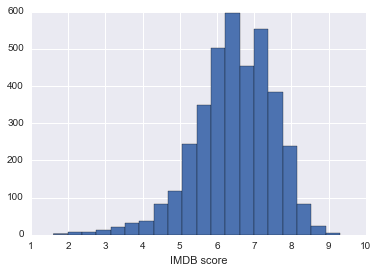

C:\Python27\Lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Python27\Lib\site-packages\sklearn\preprocessing\data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Python27\Lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains

Minimum Square Error 0    0.018214
dtype: float64
R-Square: 0.0301028409777
correlation with director_facebook_likes is: 0.192313548643
correlation with gross is: 0.214739712176
correlation with num_voted_users is: 0.482429606479
correlation with num_critic_for_reviews is: 0.347885638604
correlation with num_user_for_reviews is: 0.325002592496
correlation with budget is: 0.0291897224546
correlation with movie_facebook_likes is: 0.281154991472
correlation with duration is: 0.366221017357
correlation with actor_3_facebook_likes is: 0.0655436116815
correlation with actor_1_facebook_likes is: 0.0935971797263
correlation with actor_2_facebook_likes is: 0.102372039041
correlation with cast_total_facebook_likes is: 0.106802526649
correlation with facenumber_in_poster is: -0.0654926113212
correlation with profit is: 0.0369819844511
In the movie data, 642 out of 3756 directors_facebook_like are 0
In the movie data, 1742 out of 3756 movie_facebook_like are 0
Minimum Square Error with few numeric

C:\Python27\Lib\site-packages\sklearn\linear_model\least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 45 iterations, i.e. alpha=4.546e-04, with an active set of 45 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
C:\Python27\Lib\site-packages\sklearn\linear_model\least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 84 iterations, i.e. alpha=1.845e-04, with an active set of 84 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
C:\Python27\Lib\site-packages\sklearn\linear_model\least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 84 iterations, i.e. alpha=1.845e-04, with an active set of 84 regressors, and the smallest cholesky pivot element being 8.941e-08
  ConvergenceWarning)
C:\Python27\Lib\site-packages\sklearn\linear_model\least_angle.py:309: Conve

0.000186200848967
Rsq Lasso:  0.398383567752
CV score for LASSO:  0.406879856805
CV score for RF:  0.494147084871
R square for RF:  0.530815302565
['num_voted_users', u'genres_drama', 'budget', 'duration', 'num_user_for_reviews', 'gross', 'num_critic_for_reviews', 'profit', 'movie_facebook_likes', 'director_facebook_likes']


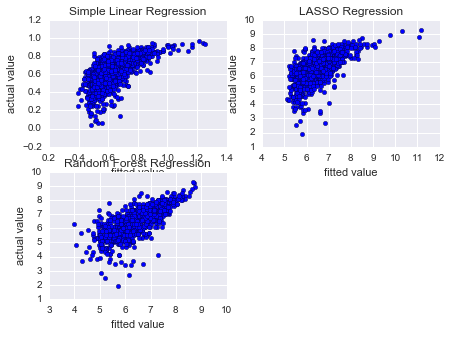

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import Preprocessor
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, LassoLarsIC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics, preprocessing, cross_validation
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import seaborn as sns

def token(text):
    return(text.split("|"))

def scaler(data,target):
    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    target = pd.DataFrame(scaler.fit_transform(target))
    return data,target

%pylab inline
#Reading from csv and Cleaning
imdb_movie = Preprocessor.data
imdb_movie['profit'] = imdb_movie['gross'] - imdb_movie['budget']

print len(imdb_movie)

##################################
#Plotting histogram for imdb_score
##################################

imdb_score = imdb_movie['imdb_score']
plt.hist(imdb_score,bins=20)
plt.xlabel('IMDB score')
plt.show()

list_fig = ['director_facebook_likes','gross','num_voted_users','num_critic_for_reviews','num_user_for_reviews','budget',\
            'movie_facebook_likes','duration','actor_3_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes',\
           'cast_total_facebook_likes','facenumber_in_poster','profit']

data,target = Preprocessor.getX_y(targetColumn='imdb_score',featureColumns=list_fig)
targetcol = 'imdb_score'

data,target = scaler(data,target)

###################
#Correlation Plot
###################
# corr = data.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
# plt.figure(figsize=(12, 12))
# sns.heatmap(corr, vmax=1, square=True)
# plt.show()


xtrain, xtest, ytrain, ytest = train_test_split(data,target,train_size=0.75)

###########################################
#First step: Using Simple Linear Regression
###########################################

model = LinearRegression()
model.fit(xtrain,ytrain)
pred = model.predict(xtest)
mse = np.mean((pred - ytest) ** 2)
print 'Minimum Square Error', mse
print 'R-Square:', model.score(xtest,ytest)

###############
# Scatter plots
###############

# plt.figure(figsize=(7,10))
# for i in range(len(list_fig)):
#     plt.subplot(8,2,i+1)
#     plt.title(list_fig[i])
#     plt.scatter(target,data[list_fig[i]],marker='x',color='r',label='dir_score')    
# plt.tight_layout()
# plt.show()

for i in list_fig:
    corre = np.corrcoef(imdb_movie[i],imdb_movie['imdb_score'])
    print 'correlation with', i , 'is:', corre[0][1]

#------------------------------------------------
imdb_movie_dir = imdb_movie[imdb_movie['director_facebook_likes']==0]
print 'In the movie data,',imdb_movie_dir.shape[0],'out of', imdb_movie.shape[0],'directors_facebook_like are 0'

imdb_movie_ml = imdb_movie[imdb_movie['movie_facebook_likes']==0]
print 'In the movie data,',imdb_movie_ml.shape[0],'out of', imdb_movie.shape[0],'movie_facebook_like are 0'

#############################################
#Second Step: Removing Few Numerical Features
#############################################

remove_list = ['director_facebook_likes','movie_facebook_likes']
for rm in remove_list:
    list_fig.remove(rm)

data,target = Preprocessor.getX_y(targetColumn='imdb_score',featureColumns=list_fig)
targetcol = 'imdb_score'

data,target = scaler(data,target)

xtrain, xtest, ytrain, ytest = train_test_split(data,target,train_size=0.75)

model_2 = LinearRegression()
model_2.fit(xtrain,ytrain)
pred = model_2.predict(xtest)
mse2 = np.mean((pred - ytest) ** 2)
print 'Minimum Square Error with few numeric', mse2
print 'R-Square with few numeric:', model_2.score(xtest,ytest)
    
###############################################
#Third step: Including text/categorical feature
###############################################

vectorizer = TfidfVectorizer(tokenizer=token)
genre = vectorizer.fit_transform(imdb_movie['genres'])
genres_list = ["genres_"+ i for i in vectorizer.get_feature_names()]

vectorizer_pk = TfidfVectorizer(max_features=50,tokenizer=token)
pk = vectorizer_pk.fit_transform(imdb_movie['plot_keywords'])
pk_list = ["pk_"+ i for i in vectorizer_pk.get_feature_names()]

vectorizer_c = TfidfVectorizer()
c = vectorizer_c.fit_transform(imdb_movie['country'])
c_list = ["c_"+ i for i in vectorizer_c.get_feature_names()]

new_data = np.hstack([data.ix[:,list_fig],genre.todense(),pk.todense(),c.todense()])
new_coeff_list = list_fig+genres_list+pk_list+c_list

xtrain, xtest, ytrain, ytest = train_test_split(new_data,target,train_size=0.5)

model_3 = LinearRegression()
model_3.fit(xtrain,ytrain)
pred = model_3.predict(xtest)
mse3 = np.mean((pred - ytest) ** 2)
print 'Minimum Square Error with numeric+text', mse3
print 'R-Square with numeric+text:', model_3.score(xtest,ytest)

plt.figure(figsize=(7,5))

plt.subplot(221)
plt.scatter(pred , ytest)
plt.title("Simple Linear Regression")
plt.xlabel("fitted value")
plt.ylabel("actual value")

####################################
#Using LASSO Regression
####################################

list_fig = ['director_facebook_likes','gross','num_voted_users','num_critic_for_reviews','num_user_for_reviews','budget',\
            'movie_facebook_likes','duration','actor_3_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes',\
           'cast_total_facebook_likes','facenumber_in_poster','profit']

# data,target = Preprocessor.getX_y(targetColumn='imdb_score',featureColumns=list_fig)
# targetcol = 'imdb_score'

# data,target = scaler(data,target)

data = imdb_movie[list_fig]
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
target = imdb_movie['imdb_score']

vectorizer = TfidfVectorizer(tokenizer=token)
genre = vectorizer.fit_transform(imdb_movie['genres'])
genres_list = ["genres_"+ i for i in vectorizer.get_feature_names()]

vectorizer_pk = TfidfVectorizer(max_features=50,tokenizer=token)
pk = vectorizer_pk.fit_transform(imdb_movie['plot_keywords'])
pk_list = ["pk_"+ i for i in vectorizer_pk.get_feature_names()]

vectorizer_c = TfidfVectorizer()
c = vectorizer_c.fit_transform(imdb_movie['country'])
c_list = ["c_"+ i for i in vectorizer_c.get_feature_names()]

new_data = np.hstack([data.ix[:,list_fig],genre.todense(),pk.todense(),c.todense()])
new_coeff_list = list_fig+genres_list+pk_list+c_list


xtrain, xtest, ytrain, ytest = train_test_split(new_data,target,train_size=0.75)

aic_m = LassoLarsIC(criterion='aic')
aic_m.fit(xtrain, ytrain)
alphas_ = aic_m.alphas_
criterion_ = aic_m.criterion_
# plt.subplot(224)
# plt.plot(-np.log10(alphas_), criterion_, '--', color='b',
#              linewidth=3)
# plt.show()
print aic_m.alpha_

model_L = Lasso(alpha=aic_m.alpha_)
model_L.fit(xtrain,ytrain)
ypred = model_L.predict(xtest)
score = cross_val_score(model_L, new_data, target,cv=5)
mse2 = (np.mean((ypred - ytest) ** 2))
rsq = model_L.score(xtest,ytest)

print 'Rsq Lasso: ', rsq
print 'CV score for LASSO: ',np.mean(score)

########################################
#Using Random Forest Regression
########################################

rf = RandomForestRegressor()
rf.fit(xtrain, ytrain)
scores = cross_val_score(rf,new_data,target,cv=5)
print 'CV score for RF: ',np.mean(scores)
pred_rf = rf.predict(xtest)
mse4 = np.mean((pred_rf - ytest) ** 2)
rsq1 = rf.score(xtest,ytest)
print 'R square for RF: ', rsq1


plt.subplot(222)
plt.scatter(ypred,ytest)
plt.title("LASSO Regression")
plt.xlabel("fitted value")
plt.ylabel("actual value")

plt.subplot(223)
plt.scatter(pred_rf, ytest)
plt.title("Random Forest Regression")
plt.xlabel("fitted value")
plt.ylabel("actual value")


#####################################
#Find to 10 predictors
#####################################
indices = np.argsort(rf.feature_importances_)[::-1]
top10 = indices[0:10]

f=[]
for i in top10:
    f.append(new_coeff_list[i])
    
print f


Populating the interactive namespace from numpy and matplotlib
Index([u'Steven Spielberg', u'Ridley Scott', u'Tim Burton', u'Clint Eastwood',
       u'Christopher Nolan', u'Steven Soderbergh', u'Peter Jackson',
       u'Martin Scorsese', u'Sam Raimi', u'Zack Snyder', u'David Fincher',
       u'Woody Allen', u'Sam Mendes', u'Michael Bay', u'Quentin Tarantino',
       u'Danny Boyle', u'Ethan Coen', u'Ron Howard', u'Bryan Singer',
       u'Robert Zemeckis'],
      dtype='object', name=u'director_name')


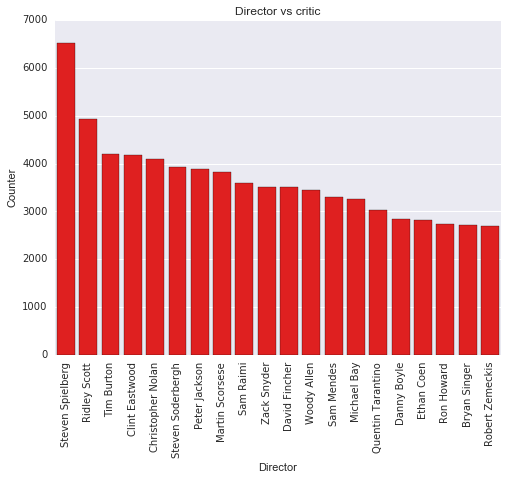

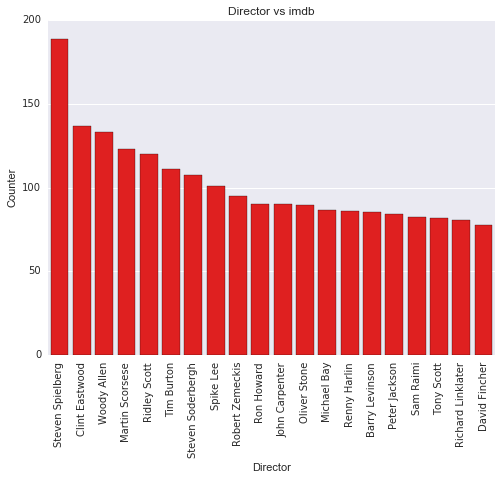

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%pylab inline
#Reading from csv
imdb_movie_base = pd.read_csv('C:/Users/schttrj1/Desktop/CompBackup/Courses_Fall_2016/Data_Science_Appln/Final Project/movie_metadata.csv')

#Cleaning the data
imdb_movie = imdb_movie_base.dropna(axis=0)    

#Director v Critic
director_tot = imdb_movie.groupby(imdb_movie['director_name'])['num_critic_for_reviews'].sum()
dir_names = director_tot.sort_values(ascending=False)[:20].index
dir_critic = director_tot.sort_values(ascending=False)[:20].values
print dir_names
fig,ax = plt.subplots(figsize=(8,6))
sns.barplot(x = dir_names,
            y = dir_critic,
            color='r')
ticks = plt.setp(ax.get_xticklabels(),rotation=90)
plt.title('Director vs critic')
plt.ylabel('Counter')
plt.xlabel('Director')

#Director v imdb
director_tot_ = imdb_movie.groupby(imdb_movie['director_name'])['imdb_score'].sum()
dir_names_ = director_tot_.sort_values(ascending=False)[:20].index
dir_critic_ = director_tot_.sort_values(ascending=False)[:20].values

fig,ax = plt.subplots(figsize=(8,6))
sns.barplot(x = dir_names_,
            y = dir_critic_,
            color='r')
ticks = plt.setp(ax.get_xticklabels(),rotation=90)
plt.title('Director vs imdb')
plt.ylabel('Counter')
plt.xlabel('Director')


In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, LinearRegression, LassoLarsIC
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import scale,MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
import seaborn as sns

%pylab inline
#Reading from csv
imdb_movie_base = pd.read_csv('C:/Users/schttrj1/Desktop/CompBackup/Courses_Fall_2016/Data_Science_Appln/Final Project/movie_metadata.csv')
imdb_movie_base['profit'] = imdb_movie_base['gross'] - imdb_movie_base['budget']

#Cleaning the data
imdb_movie = imdb_movie_base.dropna(axis=0)
print len(imdb_movie)

list_fig = ['director_facebook_likes','gross','num_voted_users','num_critic_for_reviews','num_user_for_reviews','budget',\
            'movie_facebook_likes','duration','actor_3_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes',\
           'cast_total_facebook_likes','facenumber_in_poster','profit']

data = imdb_movie[list_fig]
target = imdb_movie['imdb_score']
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
IMDB_best2 = SelectKBest(f_regression, k=10).fit_transform(data, target) 
print IMDB_best2.itemset
target = imdb_movie['imdb_score']
# print data

Populating the interactive namespace from numpy and matplotlib
3756
<built-in method itemset of numpy.ndarray object at 0x19DA5098>
